In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import platform
import time
import pathlib
import os
from tqdm import tqdm

In [2]:
# retrieve filtered data
filtered_data = []
path = os.getcwd()
os.chdir("../")
with open(os.getcwd() + "/recipes_data/recipes_filtered.txt", "r") as f:
    for recipe in f:
        filtered_data.append(recipe.replace("~~", "\n"))
os.chdir(path)

In [3]:
# create vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True, filters='', lower=False, split='')
tokenizer.fit_on_texts(["~"])
tokenizer.fit_on_texts(filtered_data)

# vectorize data
dataset_vectorized = tokenizer.texts_to_sequences(filtered_data)

VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

In [4]:
# convert vectorized recipe to string
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    return recipe_stringified[::2]

In [5]:
# pad recipes with stop signs
MAX_RECIPE_LENGTH = 2012

dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences(["~"])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences(["~"])[0]
)

In [6]:
# create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

In [7]:
# Batch size.
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<RepeatDataset element_spec=(TensorSpec(shape=(64, 2012), dtype=tf.int32, name=None), TensorSpec(shape=(64, 2012), dtype=tf.int32, name=None))>


In [8]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2

tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))
# The model will take as input an integer matrix of size (batch, input_length).
# The largest integer (i.e. word index) in the input should be no larger than 9 (tmp_vocab_size).
# Now model.output_shape == (None, 10, 64), where None is the batch dimension.
tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)

1/1 [==============================] - 0s 69ms/step


2023-04-24 18:53:41.632580: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (64, None, 256)           43520     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 170)           174250    
                                                                 
Total params: 5,464,746
Trainable params: 5,464,746
Non-trainable params: 0
_________________________________________________________________


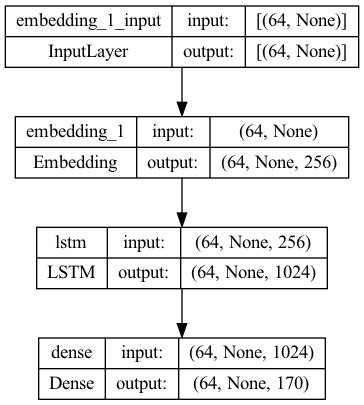

In [10]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

In [10]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

In [11]:
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [13]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [15]:
EPOCHS = 20
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 5

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           20
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  5


In [16]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

Epoch 2/20
5/5 [==============================] - 124s 25s/step - loss: 4.1120
Epoch 3/20
5/5 [==============================] - 140s 29s/step - loss: 2.2275
Epoch 4/20
4/5 [=======================>......] - ETA: 49s - loss: 2.0308 

KeyboardInterrupt: 

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)